# Simulacija POPC membrane

Simulirali boste modelno membrano, sestavljeno iz molekul 1-palmitoil-2-oleoil-glicero-3-fosfoholina (POPC) pri sobni temperaturi in atmosferskem tlaku. Za čim bolj realistično situacijo, bo membrana obdana s topilom - vodo. Uporabili boste odprtokodni program GROMACS in polje sil (t.j. opis interakcij med delci) Martini 3. 

V polju sil Martini je več atomov vnaprej združenih v "psevdo-atome", kar pomeni, da je opis manj natančen kot bi bil, če bi se ukvarjali z vsakim atomom posebej. Kljub temu, je v primeru membran fizikalna slika precej dobro predstavljena, za simulacije v spodnjem obsegu pa ne potrebujemo superračunalnika.

**Oglejte si:**
- Souza, P.C.T., Alessandri, R., Barnoud, J. et al. Martini 3: a general purpose force field for coarse-grained molecular dynamics. Nat Methods 18, 382–388 (2021). https://doi.org/10.1038/s41592-021-01098-3
- https://www.gromacs.org/

Kontakt: anze.hubman@ki.si

#### Uvozimo zahtevane programske knjiznice:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#### 0. Generiranje zacetnih koordinat:

Vhodne koordinate, zbrane v datoteki bilayer.gro so bile predhodno generirane s programom insane.py, ki so ga spisali razvijalci polja sil Martini. Program omogoča generiranje "razumnega" začetnega stanja, ki je precej blizu dejanskemu: lipidni dvosloj, ki je z vsake strani simetrično obdan z vodo. Hidrofilni deli verig so vodi izpostavljeni, hidrofobni pa skriti v notranjosti membrane.

V principu bi lahko simulacijo začeli tudi s povsem naključnimi orientacijami lipidnih verig, vendar bi v tem primeru morali izvesti precej dolgo simulacijo in počakati, da se dvosloj tvori spontano.

#### 1. Minimizacija:

Energijska minimizacija je nujen predhodni korak vsake simulacije molekulske dinamike. Kljub temu, da smo v prehodnem koraku sestavili kolikor je možno dober začetni približek, so med nekaterimi atomi še vedno prisotne nerealistično visoke sile. Z minimizacijo se takšnih kontaktov znebimo. V primeru, da bi ta korak izpustili, bi tekom simulacije visoke sile povzročile izjemne pospeške določenih atomov in sistem bi postal nestabilen. V žargonu rečemo, da "sistem raznese".

In [ ]:
!gmx grompp -f minimizacija.mdp -c bilayer.gro -p topol.top -o min.tpr

In [ ]:
!gmx mdrun -deffnm min

Uspešnost minimizacije najlažje preverimo tako, da si ogledamo potek spreminjanja potencialne energije v odvisnosti od minimizacijskega koraka. Ko se vrednost potencialne energije ustali, lahko minimizacijo ustavimo. Oglejmo si omenjen potek za naš primer:

In [ ]:
!echo 5 | gmx energy -f min.edr -o pe_minimizacija.xvg -xvg none

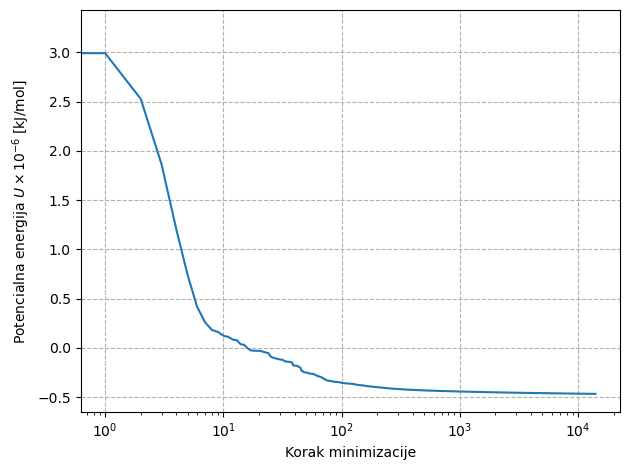

In [38]:
data = np.loadtxt('pe_minimizacija.xvg')
plt.xlabel(r'Korak minimizacije')
plt.ylabel(r'Potencialna energija $U \times 10^{-6}$ [kJ/mol]')
plt.grid(linestyle='--')
plt.semilogx(data[:,0],data[:,1]*1e-6)
plt.tight_layout()
plt.show()

#### 2. Simulacija molekulske dinamike:

Minimizirana struktura bo predstavljala naše začetne koordinate za simulacijo MD. Potrebujemo še začetne hitrosti, ki jih bomo naključno jemali iz Boltzmannove porazdelitve pri T = 300 K in jih pripisali atomom v našem sistemu. Simulirali bomo 10 ns življenja naše membrane s korakom 20 fs. 

In [ ]:
!gmx grompp -f dinamika.mdp -c min.gro -p topol.top -o din.tpr

In [ ]:
!gmx mdrun -deffnm din -v

Oglejmo si, kaj se tekom simulacije dogaja s temperaturo in potencialno energijo sistema:

In [ ]:
!echo 5 | gmx energy -f din.edr -o pe_dinamika.xvg -xvg none

In [ ]:
!echo 9 | gmx energy -f din.edr -o T_dinamika.xvg -xvg none

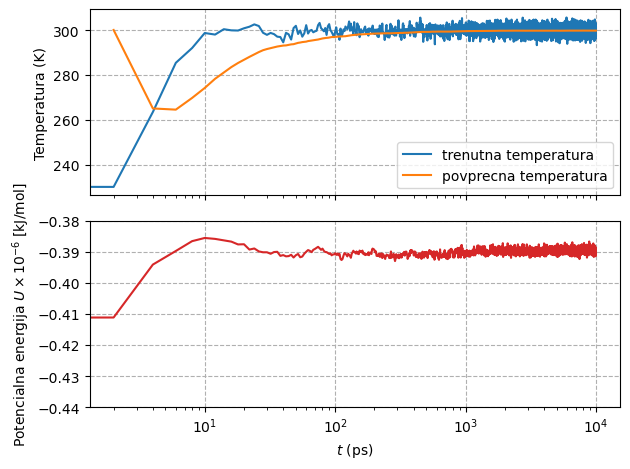

In [37]:
fig, ax = plt.subplots(2,1,sharex=True)
Trun = []
trun = []
temp = np.loadtxt('T_dinamika.xvg')
for i in range(1,temp.shape[0]):
    Trun.append(np.mean(temp[:i,1]))
    trun.append(i*(temp[1,0]-temp[0,0]))
ax[0].semilogx(temp[:,0],temp[:,1],label='trenutna temperatura')
ax[0].semilogx(trun,Trun,label='povprecna temperatura')
#ax[0].set_xlabel(r'$t$ (ps)')
ax[0].set_ylabel(r'Temperatura (K)')
ax[0].grid(linestyle='--')
ax[0].legend()

pot = np.loadtxt('pe_dinamika.xvg')
ax[1].semilogx(pot[:,0],pot[:,1]*1e-6,color='tab:red')
ax[1].set_xlabel(r'$t$ (ps)')
ax[1].set_ylabel(r'Potencialna energija $U \times 10^{-6}$ [kJ/mol]')
ax[1].set_ylim([-0.44,-0.38])
ax[1].grid(linestyle='--')
plt.tight_layout()
plt.show()

Opazimo, da se obe količini po nekaj ps ustalita, vendar kljub temu oscilirata okoli ravnovesne lege. Takšne oscilacije so v mikroskopskih sistemih neizogibne. Z večanjem števila delcev sicer postanejo zanemarljive in jih v vsakdanjem svetu ne moremo neposredno zaznati.

#### 3. Vizualizacija:

Oglejmo si še filmček naše simulacije. Odprite nov terminal in ponovno poženite ukaze:

1. conda activate membrane
2. vmd min.gro din.xtc

Odpre se vam okno programa VMD, kjer vidite naš sistem. V polju Graphics > Representations > Drawing Method izberite možnost VDW. Filmček poženete s pritiskom na znak Play v spodnjem desnem kotu okna VMD Main. 

Če pozorno opazujete membrano, boste opazili gibanje, ki spominja na valovanje. Takšnim valovom rečemo undulacije in so univerzalna lastnost membran. Nakazujejo na dejstvo, da so membrane v resnici precej mehke strukture na katere vplivajo že nihanja temperature. Jakost undulacij je odvisna tudi od morebitnih vključkov, ki se pojavljajo v realnih membranah. Eden izmed takih vključkov je vsem znani holesterol, ki med drugim regulira rigidnost membran. Obstaja še drugačen način gibanja, ki se odvija v smeri normale na membrano - peristaltična gibanja, ki pa so v našem primeru težko opazna.

Matematična analiza opisanih valovanj je precej zapletena in zahteva znanje Fourierove analize. Več si lahko preberete v:
E. Lindal, O. Edholm. Mesoscopic Undulations and Thickness Fluctuations in Lipid Bilayers from Molecular Dynamics Simulations, Biophysical Journal, Volume 79, Issue 1, 426 - 433.